# Mask generating algorithm

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import json
# Load the environment configuration JSON data
json_path = 'env_config.json'
with open(json_path, 'r') as file:
    env_config = json.load(file)

hf_home = env_config['HF_HOME']
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = hf_home
# Set the access token to huggingface hub
access_token = env_config['access_token']
os.environ['HUGGINGFACE_HUB_TOKEN'] = access_token
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

accelerator = Accelerator()
device = accelerator.device

# Load Model

In [2]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


# Peft Model

In [3]:
from peft import LoraConfig, get_peft_model
# We use the same foundation model
exp_base_model = ViTModel.from_pretrained(pretrained_name)

# convert to peft model and ready to use LoRA 
# 手动列出所有层的目标模块

target_modules = []
num_layers = 12  # BERT-base 有 12 层
for i in range(num_layers):
    target_modules.extend([
        f"encoder.layer.{i}.attention.attention.query",
        f"encoder.layer.{i}.attention.attention.key",
        f"encoder.layer.{i}.attention.attention.value",
        f"encoder.layer.{i}.attention.output.dense",
        f"encoder.layer.{i}.intermediate.dense",
        f"encoder.layer.{i}.output.dense"
    ])

lora_config = LoraConfig(
    r=4,  # 低秩矩阵的秩
    lora_alpha=32,  # LoRA 的缩放因子
    target_modules= target_modules,  # 目标模块
    lora_dropout=0.1  # Dropout 概率
)
exp_base_model = get_peft_model(exp_base_model, lora_config)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load MaskGeneratingModel

In [4]:
from maskgen.vision_models.vision_maskgen_clip_v5 import MaskGeneratingModel

mask_gen_model = MaskGeneratingModel(base_model=exp_base_model, hidden_size=config.hidden_size, num_classes=config.num_labels, config=None)
mask_gen_model.to(device)
print()
# mask_gen_model.load_state_dict(torch.load('trained/vision_clip_step80_20241212-150002.pt'))
mask_gen_model.load_state_dict(torch.load('trained/peft_v5_eternal-wood-14_epoch_1_step_200_vision_clip_20241219-225923.pt'))
# mask_gen_model.load_state_dict(torch.load('mask_gen_model/mask_gen_model_final_4_39.pth'))
mask_gen_model.eval()

patch_size = 14
print()

/tmp/1034651.1.gpu/ipykernel_2921215/1342179919.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mask_gen_model.load_state_dict(torch.load('trained/peft_v5_eternal-wood-1

## Show Example

# Demo trained examples

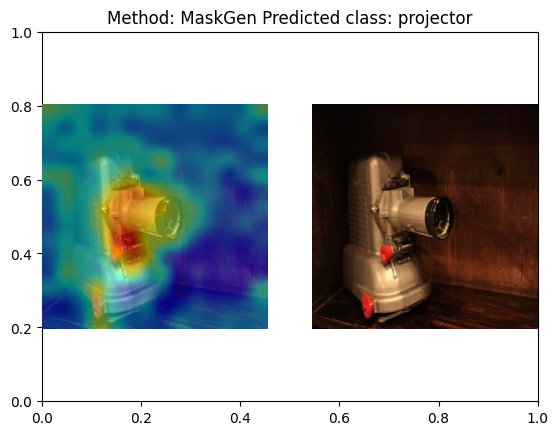

In [7]:
from maskgen.utils.img_utils import plot_overlap_np, plot_overlap

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
# url = "http://farm9.staticflickr.com/8490/8179481059_41be7bf062_z.jpg"
# url = "http://farm1.staticflickr.com/76/197438957_b20800e7cf_z.jpg"
# url = "http://farm3.staticflickr.com/2284/5730266001_7d051b01b7_z.jpg"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03000684_chain_saw.JPEG?raw=true"
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n04009552_projector.JPEG?raw=true"

image = Image.open(requests.get(url, stream=True).raw)


with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()
    secondary_class_idx = pred_model(img).logits.argsort(descending=True)[0][1].item()

# random number range from 0 to 999
# label = random.randint(0, 999)
# label = secondary_class_idx
label = predicted_class_idx
label = torch.tensor([label]).to(device)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[label.item()]}")
dist, value, _ = mask_gen_model.get_dist_critic(img, label)
sim_logits = dist.logits
N = inputs['pixel_values'].shape[0]
size = 14

# heatmap = torch.sigmoid(sim_logits).reshape(N, size, size)
heatmap = mask_gen_model.attribute_img(img, label, image_size=224, patch_size=16)
# heatmap = sim_logits.reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)


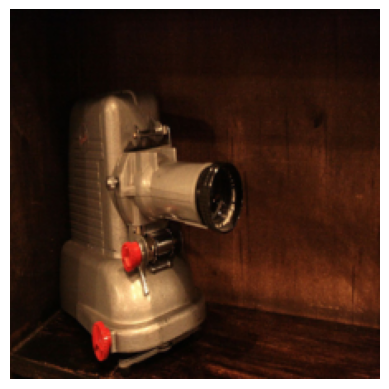

In [32]:
# display only the image without axis and titles 
plt.axis('off')
plt.imshow(img_int)

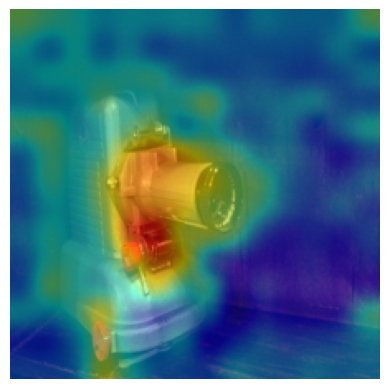

In [8]:
plot_overlap(img_int, heatmap_img)

In [9]:
print("min", heatmap.min())
print("max", heatmap.max())

heatmap

# min 0.041631065
# max 0.9540452

min 0.46882385
max 0.57080686


array([[0.5214898 , 0.5145727 , 0.50939083, 0.5020364 , 0.50561047,
        0.504359  , 0.5056755 , 0.5041459 , 0.49396557, 0.50352263,
        0.49903595, 0.49867833, 0.4990948 , 0.52117246],
       [0.5078741 , 0.49319732, 0.5115717 , 0.49332866, 0.50391227,
        0.48881626, 0.49425542, 0.49593538, 0.49563286, 0.49394345,
        0.49557218, 0.4939731 , 0.5061434 , 0.49127218],
       [0.5021582 , 0.51106316, 0.5087776 , 0.5092998 , 0.5112961 ,
        0.5154688 , 0.49727184, 0.49228862, 0.49352488, 0.4967372 ,
        0.49071753, 0.48959655, 0.4928277 , 0.5047875 ],
       [0.49973866, 0.49661064, 0.5028647 , 0.5192789 , 0.50368696,
        0.5065092 , 0.5121599 , 0.5266019 , 0.49783006, 0.49965608,
        0.5024609 , 0.50889385, 0.49353456, 0.49090672],
       [0.5179996 , 0.5228694 , 0.50095665, 0.5054742 , 0.5118712 ,
        0.5278358 , 0.4949246 , 0.5079634 , 0.49374995, 0.49443862,
        0.50358176, 0.48232046, 0.4989473 , 0.51257956],
       [0.49511215, 0.516379  , 0.5

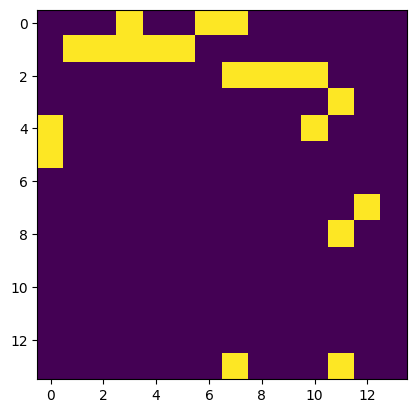

In [35]:
# test_mask = obtain_masks_on_topk(heatmap, 20, 'ins')
plt.imshow((heatmap > np.quantile(heatmap, 0.9)))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.show()

# Batch Evaluation

In [10]:
from torch.utils.data import DataLoader

def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)
train_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 1000
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
# test_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [11]:
from maskgen.evaluation import EvalGame
from tqdm import tqdm

# n_samples = 100

# random_mask
root_path = 'results/vision-clip-peft-vit'

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)

    attr = mask_gen_model.attribute_img(pixel_values, pseudo_label)

    heatmap = attr # [1, 14, 14]
    # heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    heatmap_list.append(heatmap)
    # if (idx + 1) * batch_size % 100 == 0:
    #     heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
    #     save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
    #     heatmap_list = []


if len(heatmap_list) > 0:
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)

# heatmap = heatmap_list

5it [00:51, 10.31s/it]


In [12]:
# if len(heatmap_list) > 0:
#     heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
#     save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)

# Get accuracy of the topk masked inputs

In [13]:
import torch 
import numpy as np
from torch.nn import functional as F

# hm_path = 'results/maskgen-vit/heatmap-5000.npy'
# hm_path = 'results/rise-vit/heatmap-5000.npy'
hm_path = 'results/vision-clip-peft-vit/heatmap-5000.npy'

def obtain_masks_on_topk(attribution, topk, mode='positive'):
    """ 
    attribution: [N, H_a, W_a]
    """
    H_a, W_a = attribution.shape[-2:]
    attribution = attribution.reshape(-1, H_a * W_a) # [N, H_a*W_a]
    attribution_perturb = attribution + 1e-6*torch.randn_like(attribution) # to avoid equal attributions (typically all zeros or all ones)
    
    attribution_size = H_a * W_a
    topk_scaled = int(topk * attribution_size / 100)
    if mode == 'positive':
        a, _ = torch.topk(attribution_perturb, k=topk_scaled, dim=-1)
        a = a[:, -1].unsqueeze(-1)
        mask = (attribution_perturb <= a).float()
    elif mode == 'negative':
        a, _ = torch.topk(attribution_perturb, k=topk_scaled, dim=-1, largest=False)
        a = a[:, -1].unsqueeze(-1)
        mask = (attribution_perturb >= a).float()
        # a, _ = torch.topk(attribution_perturb, k=topk_scaled, dim=-1)
        # a = a[:, -1].unsqueeze(-1)
        # mask = (attribution_perturb >= a).float()

    else:
        raise ValueError('Enter game mode either as positive or negative.')
    return mask.reshape(-1, H_a, W_a) # [N, H_a*W_a]


def obtain_masked_input_on_topk(x, attribution, topk, mode='positive'):
    """ 
    x: [N, C, H, W]
    attribution: [N, H_a, W_a]
    """
    mask = obtain_masks_on_topk(attribution, topk, mode)
    mask = mask.unsqueeze(1) # [N, 1, H_a, W_a]
    mask = F.interpolate(mask, size=x.shape[-2:], mode='nearest')

    masked_input = x * mask

    # mean_pixel = masked_input.sum(dim=(-1, -2), keepdim=True) / mask.sum(dim=(-1, -2), keepdim=True)
    mean_pixel = x.mean(dim=(-1, -2), keepdim=True)
    masked_input = masked_input + (1 - mask) * mean_pixel

    return masked_input

def load_heatmap(path='results/maskgen-vit/heatmap-5000.npy', batch_size=1000):
    heatmap = np.load(path)
    heatmap = torch.tensor(heatmap) # [N, 1, 14, 14]
    batches = torch.split(heatmap, batch_size, dim=0)
    return batches


topk = 20
# divide heatmap into batches of size batch_size
heatmap_batches = load_heatmap(path=hm_path, batch_size=1000)

total_acc = []
for topk in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    for idx, data in tqdm(enumerate(zip(test_dataloader, heatmap_batches))):
        pixel_values = data[0]['pixel_values'].to(device) # [N, C, H, W]
        attribution = data[1].to(device) # [N, 1, 14, 14]
        with torch.no_grad():
            pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)
            masked_input = obtain_masked_input_on_topk(pixel_values, attribution, topk, mode='negative')
            logits = pred_model(masked_input).logits
            preds = logits.argmax(-1).view(-1)
            acc = (pseudo_label == preds).float().mean().item()
            print(acc)
            total_acc.append(acc)
            break
        


0it [00:00, ?it/s]

0it [00:09, ?it/s]


0.9010000228881836


0it [00:09, ?it/s]


0.8550000190734863


0it [00:09, ?it/s]


0.8060000538825989


0it [00:09, ?it/s]


0.7550000548362732


0it [00:09, ?it/s]


0.6910000443458557


0it [00:08, ?it/s]


0.609000027179718


0it [00:09, ?it/s]


0.5070000290870667


0it [00:09, ?it/s]


0.3570000231266022


0it [00:09, ?it/s]

0.14600001275539398


In [14]:
sum(total_acc) / len(total_acc)

# negative
# 0.7702222632037269
# positive
# 0.30455556470486855

0.6252222541305754

In [41]:
total_acc

# negative
# [0.9510000348091125,
#  0.9110000729560852,
#  0.9020000696182251,
#  0.8700000643730164,
#  0.8380000591278076,
#  0.8020000457763672,
#  0.7360000610351562,
#  0.6440000534057617,
#  0.37300002574920654] = 0.7807778318723043

# posivie
# [0.7240000367164612,
#  0.5410000085830688,
#  0.40400001406669617,
#  0.28700000047683716,
#  0.1850000023841858,
#  0.125,
#  0.08500000089406967,
#  0.04200000315904617,
#  0.021000001579523087] = 0.2682222297622098


[0.9010000228881836,
 0.8330000638961792,
 0.784000039100647,
 0.734000027179718,
 0.7040000557899475,
 0.659000039100647,
 0.5920000076293945,
 0.49900001287460327,
 0.30000001192092896]

In [42]:
# ins_score = torch.stack(ins_score_list)
# del_score = torch.stack(del_score_list)

# print(ins_score.mean())
# print(del_score.mean())
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = input_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)
# tensor(0.6749, device='cuda:0')
# tensor(0.0431, device='cuda:0')

Predicted class: airship, dirigible


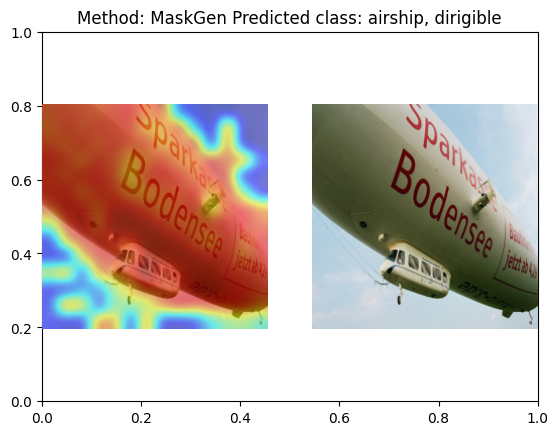

In [43]:
from maskgen.utils.img_utils import plot_overlap_np

idx = 21
predicted_class_idx = pseudo_label[idx].item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

hm = attribution[idx].detach().cpu().numpy()
img = pixel_values[idx].detach().cpu().numpy().transpose(1, 2, 0)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
# plt.annotate(f"ins_score: {ins_score[-1]:.4f}", (0, 10))
# plt.annotate(f"del_score: {del_score[-1]:.4f}", (0, 20))

img_int, heatmap_img = plot_overlap_np(img, hm, mean, std)

# print("ins_score:", ins_score[-1])
# print("del_score:", del_score[-1])

In [44]:
hm

array([[0.42122948, 0.42510456, 0.42556816, 0.41912967, 0.4274781 ,
        0.4351176 , 0.40839952, 0.42589653, 0.26635528, 0.23892775,
        0.23053315, 0.22759016, 0.22611757, 0.22751203],
       [0.41304958, 0.431427  , 0.4207009 , 0.43240052, 0.42782554,
        0.42871377, 0.3828702 , 0.39529026, 0.42741817, 0.29445305,
        0.22218728, 0.41620702, 0.22532676, 0.23231144],
       [0.42402342, 0.41693315, 0.43140242, 0.41741204, 0.43276688,
        0.42214853, 0.42793038, 0.38499272, 0.409607  , 0.43024135,
        0.24042836, 0.41694233, 0.2299294 , 0.2228684 ],
       [0.43480322, 0.42654917, 0.41173846, 0.43175787, 0.42332345,
        0.3923451 , 0.41166592, 0.4302244 , 0.40216243, 0.40608978,
        0.43227395, 0.41081384, 0.40280664, 0.26385123],
       [0.4290633 , 0.42122042, 0.43282562, 0.43601292, 0.42249507,
        0.37583807, 0.42930585, 0.4365497 , 0.43308496, 0.40758964,
        0.43014237, 0.425908  , 0.23957838, 0.23542462],
       [0.43444714, 0.43394583, 0.4

In [45]:
from maskgen.evaluation import obtain_masks_on_topk, obtain_masked_input_on_topk

test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]

mode = 'ins'
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode)
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode)
test_masked_img2 = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')

# plt.imshow((heatmap[idx] > torch.quantile(heatmap[idx], 0.8)).float().cpu().numpy())
plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
plt.show()
plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(test_masked_img2[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

NameError: name 'input_img' is not defined

In [ ]:
from maskgen.evaluation import EvalGame, obtain_masks_on_topk, obtain_masked_input_on_topk
test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]
# eval_game.get_deletion_at_topk(test_img, test_heatmap, topk)
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode='del')
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk)
 # [N, 1, H_a, W_a]
resized_mask = F.interpolate(test_mask.unsqueeze(1), size=test_img.shape[-2:], mode='nearest')

test_predicted_class_idx = pred_model(test_masked_img).logits.argmax(-1)
print("Predicted class:", pred_model.config.id2label[test_predicted_class_idx.item()])

# probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
# print(eval_game.get_score_at_topk(test_img, test_heatmap, 20, mode='del'))

test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')
probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
print(probs[:,439])


test_masked_img = obtain_masked_input_on_topk(test_img, test_mask, topk)


pseudo_label = self.model(x).argmax(-1) # [1, 1]
probs = torch.softmax(self.model(masked_input), dim=-1) # [N, 1000]

selector = idx_to_selector(pseudo_label, self.output_dim) # [N, 1000]
probs = (probs * selector).sum(-1) # [N,]
return probs # [N,]



plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.imshow((test_masked_img * resized_mask)[0].detach().cpu().numpy().transpose(1, 2, 0))

Predicted class: wing
tensor([4.2913e-08], device='cuda:0')


NameError: name 'self' is not defined

In [ ]:
# from evaluation import EvalGame
# import os 
# import re
# from tqdm import tqdm


# root_path = 'results/mask-vit'
# model = lambda x: pred_model(pixel_values=x).logits
# eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
# topk = 50

# def extract_number(filename):
#     """
#     Extract the first occurance of countinuous numbers in a file name
#     """
#     match = re.search(r'\d+', filename)
#     if match:
#         return int(match.group(0))
#     return 0

# def get_ordered_filename_list(root_path):
#     file_path_list = []
#     for filename in os.listdir(root_path):
#         if filename.endswith('.npy'):
#             file_path = os.path.join(root_path, filename)
#             file_path_list.append(file_path)
#     file_path_list = sorted(file_path_list, key=extract_number)
#     return file_path_list


# def load_heatmap(root_path):
#     file_path_list = get_ordered_filename_list(root_path)
#     for filename in file_path_list:
#        yield np.load(filename)


# ins_score_list = []
# del_score_list = []

# heatmap_generator = load_heatmap(root_path)
# test_dataloader_iterator = iter(test_dataloader)
# for idx, data in tqdm(enumerate(heatmap_generator)):
#     heatmap = torch.tensor(data, device=device)

#     with torch.no_grad():
#         # Average pooling to convert to 14*14 heatmap
#         heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
#         input_img = next(test_dataloader_iterator)['pixel_values'].to(device)
#         ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
#         del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

#         # append to list
#         ins_score_list.append(ins_score)
#         del_score_list.append(del_score)